In [2]:
import os
import torch
import pandas as pd
import anndata as ad
from collections import defaultdict
from deepsc.scgpt_utils.grn import GeneEmbedding
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from deepsc.utils.utils import extract_state_dict, sample_weight_norms, report_loading_result
from deepsc.utils.utils import report_loading_result
from deepsc.models.deepsc_new.model import DeepSC
import tqdm
import networkx as nx
import gseapy as gp
from gears import PertData
from pathlib import Path
import numpy as np

/home/angli/anaconda3/envs/deepsc/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/angli/anaconda3/envs/deepsc/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/angli/anaconda3/envs/deepsc/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/angli/anaconda3/envs/deepsc/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  return module

In [3]:
pretrained_model_path="/home/angli/baseline/DeepSC/results/latest_checkpoint_epoch3.ckpt"
data_path_dir="/home/angli/baseline/DeepSC/data/"
gene_map_path="/home/angli/baseline/DeepSC/data/gene_map.csv"

In [4]:
def load_pretrained_model( model, pretrained_model_path):
    ckpt_path = pretrained_model_path
    assert os.path.exists(ckpt_path), f"找不到 ckpt: {ckpt_path}"
    print(f"[LOAD] 读取 checkpoint: {ckpt_path}")
    raw = torch.load(ckpt_path, map_location="cpu")
    state_dict = extract_state_dict(raw)
    sample_weight_norms(model, state_dict, k=5)
    load_info = model.load_state_dict(state_dict, strict=False)
    report_loading_result(load_info)
    return model

In [5]:
import types # 导入 types 模块
model_config = {
    "embedding_dim": 256,
    "num_genes": 34683,
    "num_layers": 10,
    "num_heads": 8,
    "attn_dropout": 0.1,
    "ffn_dropout": 0.1,
    "fused": False,
    "num_bins": 5,  # 从 Hydra 变量 ${num_bin} 转换
    "mask_layer_start": 100,
    "enable_l0": False,       # 从 Hydra 变量 ${enable_l0} 转换
    "enable_mse": True,     # 从 Hydra 变量 ${enable_mse} 转换
    "enable_ce": True,       # 从 Hydra 变量 ${enable_ce} 转换
    "num_layers_ffn": 2,
    "use_moe_regressor": True,
    "number_of_experts": 3,
    "use_M_matrix": False,
    "gene_embedding_participate_til_layer": 3,
    "moe": types.SimpleNamespace(**{
        "n_moe_layers": 4,
        "use_moe_ffn": True,
        "dim": 256,
        "moe_inter_dim": 512,
        "n_routed_experts": 2,
        "n_activated_experts": 2,
        "n_shared_experts": 1,
        "score_func": "softmax",
        "route_scale": 1.0,
        "world_size": 1,
        "rank": 0,
    })
}

In [6]:
model = DeepSC(**model_config)

In [7]:
model = load_pretrained_model(model, pretrained_model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"将要使用的设备是: {device}")
# 3. 关键步骤：将加载好权重的模型整体移动到目标设备 (GPU)
model.to(device)

# 4. 验证模型现在所在的设备
current_device = next(model.parameters()).device
print(f"模型成功移动，现在所在的设备是: {current_device}")

[LOAD] 读取 checkpoint: /home/angli/baseline/DeepSC/results/latest_checkpoint_epoch3.ckpt
[LOAD] 抽样参数范数对比（加载前 -> 加载后）：
  - expression_layers.6.ffn_expr.experts.0.w1.weight: 18.485008 -> 19.341312
  - regressor.experts.0.4.weight: 18.482058 -> 18.737324
  - layers.1.ffn_gene.layers.0.0.bias: 1.190350 -> 1.649058
  - layers.8.ffn_expr.layers.1.0.weight: 9.237142 -> 10.096158
  - layers.3.ffn_expr.layers.0.0.bias: 1.160499 -> 1.126512
[LOAD] missing_keys: 0 | unexpected_keys: 0
将要使用的设备是: cuda
模型成功移动，现在所在的设备是: cuda:0


In [8]:
import pandas as pd
from collections import defaultdict
from pathlib import Path
from gears import PertData
import scanpy as sc
import numpy as np
from typing import Dict, List, Tuple, Union
gene_map_path = "/home/angli/baseline/DeepSC/data/gene_map.csv"

# 1) 读 CSV，构建映射
df = pd.read_csv(gene_map_path)
# feature_name -> id（允许重复 id）
gene2idx = dict(zip(df["feature_name"], df["id"]))
# id -> [feature_name, ...]（可选：用于反查）
idx2genes = defaultdict(list)
for name, i in zip(df["feature_name"], df["id"]):
    idx2genes[int(i)].append(name)

data_dir = Path("/home/angli/baseline/DeepSC/src/deepsc/finetune/data_path_dir")
pert_data = PertData(data_dir)
pert_data.load(data_name="adamson")
adata = sc.read(data_dir / "adamson/perturb_processed.h5ad")
ori_batch_col = "control"
adata.obs["celltype"] = adata.obs["condition"].astype("category")
adata.obs["str_batch"] = adata.obs["control"].astype(str)
adata.var["id_in_vocab"] = [gene2idx[gene]+1 if gene in gene2idx else -1 for gene in adata.var["gene_name"]]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
adata = adata[:, adata.var["id_in_vocab"] >= 0]
TF_name = 'BHLHE40'
adata = adata[adata.obs.condition.isin(['{}+ctrl'.format(TF_name), 'ctrl'])].copy()
np.unique(adata.obs.condition)
print(adata.shape)
sc.pp.highly_variable_genes(
    adata,
    layer=None,
    n_top_genes=1200,
    batch_key="str_batch",
    flavor="seurat_v3",
    subset=False,
)
adata.var.loc[adata.var[adata.var.gene_name==TF_name].index, 'highly_variable'] = True
adata = adata[:, adata.var["highly_variable"]].copy()
print(adata.shape)

Found local copy...
Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['SRPR+ctrl' 'SLMO2+ctrl' 'TIMM23+ctrl' 'AMIGO3+ctrl' 'KCTD16+ctrl']
Local copy of pyg dataset is detected. Loading...
Done!


(24767, 4079)
(24767, 1200)


In [9]:
import numpy as np
import torch
import scipy.sparse as sp

def discretize_expression_raw(input_values: torch.Tensor, num_bins: int = 5, invalid_value: float = 0.0):
    """
    基于原始表达值分箱（不写入任何归一化矩阵）。
    - 每一行用本行的 min/max 定义等宽分箱
    - 有效位置输出 1..num_bins；无效位置输出 0
    """
    assert input_values.dim() == 2, "expect 2D tensor [cells, genes]"
    B, G = input_values.shape
    out = torch.zeros((B, G), dtype=torch.long, device=input_values.device)

    for i in range(B):
        row = input_values[i]
        valid = row != invalid_value
        if not valid.any():
            continue
        vals = row[valid]
        vmin = vals.min()
        vmax = vals.max()
        if torch.isclose(vmax, vmin):
            # 有效值都相等：全部放入第1个箱
            out[i, valid] = 1
        else:
            # 等宽分箱：直接基于原始值计算箱编号（不归一化到layer）
            # bins = floor( (x - vmin) / (vmax - vmin + eps) * (num_bins-1) ) + 1
            bins = torch.floor((vals - vmin) / (vmax - vmin + 1e-8) * (num_bins - 1)).long() + 1
            bins = torch.clamp(bins, 1, num_bins)
            out[i, valid] = bins
    return out

def process_anndata(adata, num_bins: int = 5):
    X = adata.X

    # 若为稀疏，转为致密数组副本（不改动 adata.X）
    if sp.issparse(X):
        X_dense = X.toarray().astype(np.float32, copy=False)
    else:
        X_dense = np.asarray(X, dtype=np.float32)

    # ---- X_normed：原样保存 X 到 layer（不做任何变换）----
    adata.layers["X_normed"] = X_dense.copy()  # 保持与 X 相同的数值

    # ---- X_binned：基于原始 X 分箱（不归一化输出）----
    X_tensor = torch.from_numpy(X_dense)  # 只为计算分箱编号
    X_binned = discretize_expression_raw(X_tensor, num_bins=num_bins, invalid_value=0.0)
    adata.layers["X_binned"] = X_binned.cpu().numpy().astype(np.int32)

    return adata

adata=process_anndata(adata)
expr_normed = adata.layers["X_normed"]
expr_binned = adata.layers["X_binned"]
for i in range(len(adata.var["id_in_vocab"])):
    print(adata.var["id_in_vocab"][i], adata.var["gene_name"][i])

gene_ids=np.array(adata.var["id_in_vocab"])


27438 SAMD11
9673 HES4
31551 TNFRSF18
2870 CALML6
31548 TNFRSF14
28827 SMIM1
13113 LINC01134
31560 TNFRSF9
23122 RERE
5008 CTNNBIP1
29696 SPEN
289 ACTL8
10506 ID3
27347 RUNX3
27290 C1orf63
23248 RHCE
30120 STMN1
28053 SH3BGRL3
3448 CD52
27928 SESN2
28946 SNHG12
33652 YTHDF2
12370 LAPTM5
7174 FABP3
12432 LCK
31422 TMEM54
33943 ZMYM4
4316 CLSPN
7074 EVA1B
5939 DNALI1
3541 CDCA8
23245 RHBDL2
23345 RLF
31162 TMCO2
23316 RIMS3
28462 SLC2A1-AS1
3489 CDC20
34663 ZSWIM5
24462 RNF11
32535 ZCCHC11
18309 MYSM1
11492 JUN
32964 USP1
4997 CTH
5883 DNAJB4
4985 CTBS
34605 ZNHIT6
4189 CLCA1
8449 GBP2
5975 DNTTIP2
27359 RWDD3
4859 CSF1
3449 CD53
5589 DENND2D
3993 CHI3L2
30789 FAM46C
21019 PHGDH
7673 FCGR1B
32569 TXNIP
20806 PDZK1
18466 NBPF16
7672 FCGR1A
9402 HIST2H2BE
9364 HIST2H2AC
17980 MTMR11
22088 PRPF3
6335 ECM1
15421 MCL1
5035 CTSS
3526 CDC42SE1
22319 PSMD4
27750 SELENBP1
27381 S100A11
7873 FLG2
22154 PRR9
20942 PGLYRP4
27391 S100A5
27389 S100A3
27386 S100A14
27385 S100A13
27379 S100A1
26930 RPS2

In [10]:
def tokenize_and_pad_batch(
    expr_normed: np.ndarray,
    expr_binned: np.ndarray,
    gene_ids: np.ndarray,
    max_len: int,
    append_cls: bool = True,
    include_zero_gene: bool = False,
    return_pt: bool = True,
) -> Dict[str, torch.Tensor]:
    """
    Tokenize and pad a batch of data. Returns a list of tuple (gene_id, count).
    """
    cls_id = 34684
    tokenized_data = tokenize_batch(
        expr_normed,
        expr_binned,
        gene_ids,
        return_pt=return_pt,
        append_cls=append_cls,
        include_zero_gene=include_zero_gene,
        cls_id=cls_id,
    )
    batch_padded = pad_batch(
        tokenized_data,
        max_len=max_len,
        pad_value=0,
        cls_appended=append_cls,
    )
    return batch_padded

def pad_batch(
    batch: List[Tuple],
    max_len: int,
    pad_value: int = 0,
    cls_appended: bool = True,
) -> Dict[str, torch.Tensor]:
    """
    Pad a batch of data. Returns a list of Dict[gene_id, count].

    Args:
        batch (list): A list of tuple (gene_id, count).
        max_len (int): The maximum length of the batch.
        vocab (Vocab): The vocabulary containing the pad token.
        pad_token (str): The token to pad with.

    Returns:
        Dict[str, torch.Tensor]: A dictionary of gene_id and count.
    """
    max_ori_len = max(len(batch[i][0]) for i in range(len(batch)))
    max_len = min(max_ori_len, max_len)

    pad_id = 0
    gene_ids_list = []
    normed_list = []
    binned_list = []

    for i in range(len(batch)):
        gene_ids, normed, binned = batch[i]

        if len(gene_ids) > max_len:
            if not cls_appended:
                idx = np.random.choice(len(gene_ids), max_len, replace=False)
            else:
                idx = np.random.choice(len(gene_ids) - 1, max_len - 1, replace=False)
                idx = idx + 1
                idx = np.insert(idx, 0, 0)
            gene_ids = gene_ids[idx]
            normed = normed[idx]
            binned = binned[idx]
        if len(gene_ids) < max_len:
            gene_ids = torch.cat(
                [
                    gene_ids,
                    torch.full(
                        (max_len - len(gene_ids),), pad_id, dtype=gene_ids.dtype
                    ),
                ]
            )
            normed = torch.cat(
                [
                    normed,
                    torch.full((max_len - len(normed),), pad_value, dtype=normed.dtype),
                ]
            )
            binned = torch.cat(
                [
                    normed,
                    torch.full((max_len - len(binned),), pad_value, dtype=binned.dtype),
                ]
            )
        gene_ids_list.append(gene_ids)
        normed_list.append(normed)
        binned_list.append(binned)

    batch_padded = {
        "genes": torch.stack(gene_ids_list, dim=0),
        "normed": torch.stack(normed_list, dim=0),
        "binned": torch.stack(binned_list, dim=0),
    }
    return batch_padded
def tokenize_batch(
    expr_normed: np.ndarray,
    expr_binned: np.ndarray,
    gene_ids: np.ndarray,
    return_pt: bool = True,
    append_cls: bool = True,
    include_zero_gene: bool = False,
    cls_id: int = "<cls>",
) -> List[Tuple[Union[torch.Tensor, np.ndarray]]]:
    """
    Tokenize a batch of data. Returns a list of tuple (gene_id, count).

    Args:
        data (array-like): A batch of data, with shape (batch_size, n_features).
            n_features equals the number of all genes.
        gene_ids (array-like): A batch of gene ids, with shape (n_features,).
        return_pt (bool): Whether to return torch tensors of gene_ids and counts,
            default to True.

    Returns:
        list: A list of tuple (gene_id, count) of non zero gene expressions.
    """
    if expr_normed.shape[1] != len(gene_ids):
        raise ValueError(
            f"Number of features in data ({expr_normed.shape[1]}) does not match "
            f"number of gene_ids ({len(gene_ids)})."
        )
    if expr_binned.shape[1] != len(gene_ids):
        raise ValueError(
            f"Number of features in data ({expr_binned.shape[1]}) does not match "
            f"number of gene_ids ({len(gene_ids)})."
        )
    tokenized_data = []
    for i in range(len(expr_normed)):
        row_normed = expr_normed[i]
        row_binned = expr_binned[i]
        if include_zero_gene:
            values_normed = row_normed
            values_binned = row_binned
            genes = gene_ids
        else:
            idx = np.nonzero(row_normed)[0]
            values_normed = row_normed[idx]
            values_binned = row_binned[idx]
            genes = gene_ids[idx]
        if append_cls:
            genes = np.insert(genes, 0, cls_id)
            values_binned = np.insert(values_binned, 0, 0)
            values_normed = np.insert(values_normed, 0, 0)
        if return_pt:
            genes = torch.from_numpy(genes).long()
            values_normed = torch.from_numpy(values_normed).float()
            values_binned = torch.from_numpy(values_binned).long()
        tokenized_data.append((genes, values_normed, values_binned))
    return tokenized_data

In [11]:
print(expr_normed.shape)
tokenized_data = tokenize_and_pad_batch(
    expr_normed,
    expr_binned,
    gene_ids,
    max_len=len(gene_ids)+1,
    append_cls=True,
    include_zero_gene=True,
)
print(tokenized_data["genes"].shape)


(24767, 1200)
torch.Size([24767, 1201])


In [12]:

all_gene_ids, all_normed, all_binned = tokenized_data["genes"].to(device), tokenized_data["normed"].to(device), tokenized_data["binned"].to(device)
condition_ids = np.array(adata.obs["condition"].tolist())
dict_sum_condition = {}

In [13]:
batch_size = 16
model.eval()
M = all_gene_ids.size(1)
N = all_gene_ids.size(0)
device = next(model.parameters()).device
print(device)
for i in tqdm.tqdm(range(0, N, batch_size)):
    batch_size = all_gene_ids[i : i + batch_size].size(0)
    gene_embeddings = model.gene_embedding(all_gene_ids[i : i + batch_size]).to(device)
    expr_embeddings = model.expr_embedding(all_binned[i : i + batch_size],all_normed[i : i + batch_size]).to(device)
    for layer in model.layers[:10]:
        gene_embeddings, expr_embeddings = layer(gene_embeddings, expr_embeddings)
    for layer in model.expression_layers[:6]:
        expr_embeddings = layer(expr_embeddings, None)
    q,k,v = model.expression_layers[6].expr_attn.W_Q,model.expression_layers[6].expr_attn.W_K,model.expression_layers[6].expr_attn.W_V
    q = q(expr_embeddings).view(
            batch_size, 1201, 8, model_config["embedding_dim"]//8
        )
    k = k(expr_embeddings).view(
            batch_size, 1201, 8, model_config["embedding_dim"]//8
        )
    v = v(expr_embeddings).view(
            batch_size, 1201, 8, model_config["embedding_dim"]//8
        )
    q = q.transpose(1,2)
    k = k.transpose(1,2)
    v = v.transpose(1,2)
    attn_scores = q @ k.permute(0, 1, 3, 2)
    attn_scores = attn_scores.reshape((-1, M))
    order = torch.argsort(attn_scores, dim=1)
    rank = torch.argsort(order, dim=1)
    attn_scores = rank.reshape((-1, 8, M, M))/M
    # Rank normalization by column
    attn_scores = attn_scores.permute(0, 1, 3, 2).reshape((-1, M))
    order = torch.argsort(attn_scores, dim=1)
    rank = torch.argsort(order, dim=1)
    attn_scores = (rank.reshape((-1, 8, M, M))/M).permute(0, 1, 3, 2)
    # Average 8 attention heads
    attn_scores = attn_scores.mean(1)

    outputs = attn_scores.detach().cpu().numpy()

    for index in range(batch_size):
        # Keep track of sum per condition
        c = condition_ids[i : i + batch_size][index]
        if c not in dict_sum_condition:
            dict_sum_condition[c] = np.zeros((M, M), dtype=np.float32)
        else:
            dict_sum_condition[c] += outputs[index, :, :]
    

cuda:0


100%|██████████| 1548/1548 [05:33<00:00,  4.64it/s]


In [14]:
groups = adata.obs.groupby('condition').groups
dict_sum_condition_mean = dict_sum_condition.copy()
for i in groups.keys():
    dict_sum_condition_mean[i] = dict_sum_condition_mean[i]/len(groups[i])
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()
print(gene_vocab_idx)

[34684 27438  9673 ... 11382 11383  4514]


In [33]:
dict_sum_condition_mean
print(dict_sum_condition_mean['ctrl'].shape)

(1201, 1201)


In [16]:
def get_topk_most_influenced_genes(topk, setting):
    attn_top_gene_dict = {}
    attn_top_scores_dict = {}
    print(gene_vocab_idx)
    for i in groups.keys():
        if i != 'ctrl':
            knockout_gene = i.split('+')[0]
            # print(knockout_gene)
            knockout_gene_idx = np.where(gene_vocab_idx==gene2idx[knockout_gene]+1)[0][0]
            # print(knockout_gene_idx)
            # print(gene2idx[knockout_gene])
            # print(gene_vocab_idx)
            # print(knockout_gene_idx)
            # print(gene_vocab_idx)
            print(dict_sum_condition_mean['ctrl'].shape)
            control = dict_sum_condition_mean['ctrl'][:, knockout_gene_idx]
            exp = dict_sum_condition_mean[i][:, knockout_gene_idx]
            # Chnage this line to exp, control, exp-control for three different settings
            print(control.shape,exp.shape)
            if setting == 'difference':
                a = exp-control
            elif setting == 'control':
                a = control
            elif setting == 'experiment':
                a = exp
            diff_idx = np.argpartition(a, -topk)[-topk:]
            scores = (a)[diff_idx]
            gene_ids = gene_vocab_idx[diff_idx] 

            # 使用列表推导式将每个 id 转换为 gene 名称
            attn_top_genes = [idx2genes[gene_id-1][0] for gene_id in gene_ids]+ [TF_name]
            attn_top_gene_dict[i] = list(attn_top_genes)
            attn_top_scores_dict[i] = list(scores)
    return attn_top_gene_dict, attn_top_scores_dict

In [17]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [19]:
# Specify top k number of genes to be selected, and the selection setting
# Here calculate top 20 most influenced genes for CHIP-Atlas validation
topk = 20
setting = 'difference' # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_20, attn_top_scores_dict_20 = get_topk_most_influenced_genes(topk, setting)
print(attn_top_scores_dict_20[TF_name + '+ctrl'])
print(attn_top_gene_dict_20[TF_name + '+ctrl'])

[34684 27438  9673 ... 11382 11383  4514]
(1201, 1201)
(1201,) (1201,)
[0.08708757, 0.08790848, 0.08993477, 0.08852896, 0.091451705, 0.0918386, 0.0929721, 0.09198189, 0.09350994, 0.09530631, 0.09640616, 0.10549271, 0.100177705, 0.10161969, 0.09765351, 0.09630135, 0.108091, 0.10519737, 0.108094186, 0.118468404]
['ATP5MJ', 'C11orf48', 'TUBB', 'CDC20', 'SRP72', 'LAPTM5', 'VIM', 'GAL', 'UBC', 'SNHG8', 'MDK', 'ZFAS1', 'LY6E', 'ODC1', 'CALM1', 'BAG1', 'HMGB2', 'CYBA', 'CD47', 'EIF3E', 'BHLHE40']


BHLHE40+ctrl


<Figure size 1800x1800 with 0 Axes>

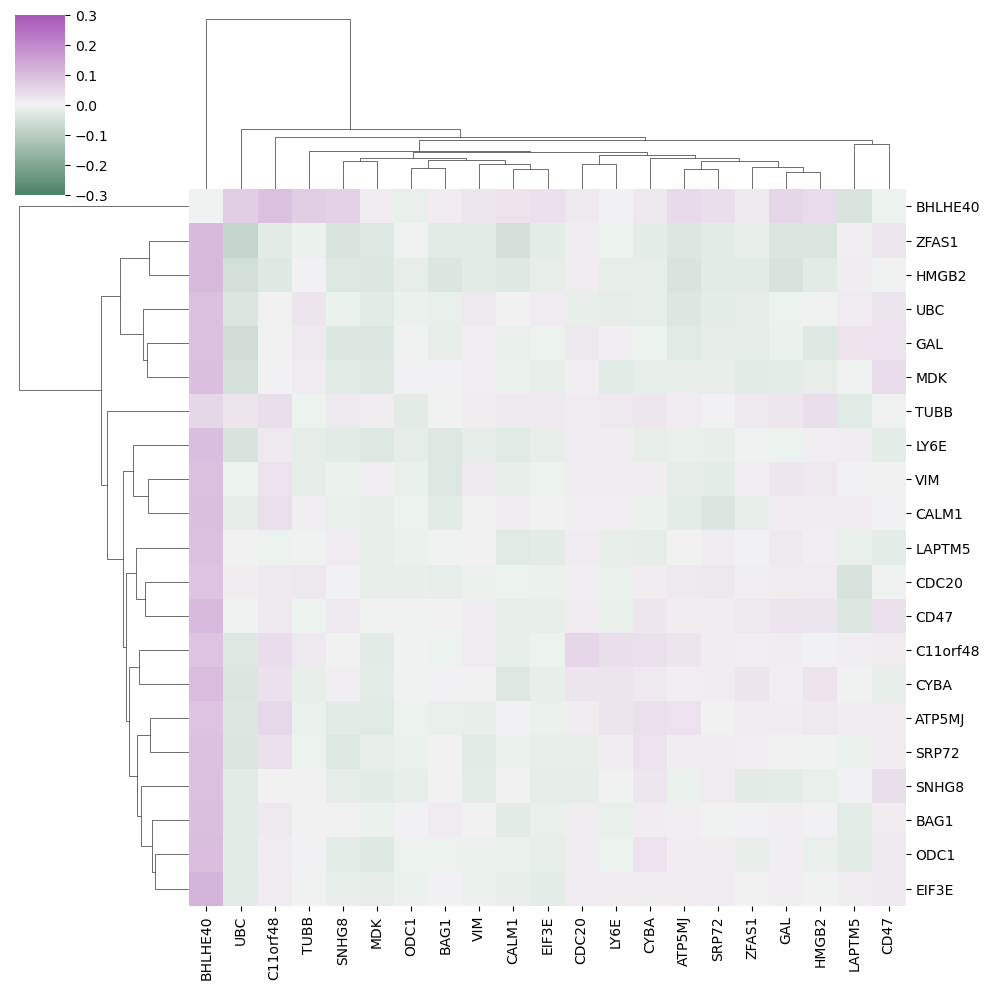

In [22]:
if setting == 'difference':
    for i in attn_top_gene_dict_20.keys():
        print(i)
        example_genes = attn_top_gene_dict_20[i]
        gene_idx = [np.where(gene_vocab_idx==gene2idx[g]+1)[0][0] for g in example_genes]
        # gene_idx = [np.where(gene_vocab_idx==gene2idx[g])[0][0] for g in example_genes]
        scores = dict_sum_condition_mean[i][gene_idx, :][:, gene_idx]-dict_sum_condition_mean['ctrl'][gene_idx, :][:, gene_idx]
        df_scores = pd.DataFrame(data = scores, columns = example_genes, index = example_genes)
        plt.figure(figsize=(6, 6), dpi=300)
        ax = sns.clustermap(df_scores, annot=False, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), fmt='.2f', vmin=-0.3, vmax=0.3) 
        plt.show()
        plt.close()

In [23]:
# Specify top k number of genes to be selected, and the selection setting
# # Here calculate top 100 most influenced genes for pathway validation
topk = 100
setting = 'difference' # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_100, attn_top_scores_dict_100 = get_topk_most_influenced_genes(topk, setting)
print(attn_top_scores_dict_100[TF_name + '+ctrl'])
print(attn_top_gene_dict_100[TF_name + '+ctrl'])

[34684 27438  9673 ... 11382 11383  4514]
(1201, 1201)
(1201,) (1201,)
[0.055784196, 0.058253884, 0.059876263, 0.060032487, 0.058477163, 0.060167015, 0.05902624, 0.06048423, 0.059242964, 0.060139537, 0.06068319, 0.059687495, 0.05642152, 0.05578655, 0.05734706, 0.058566332, 0.056647032, 0.06066537, 0.060945183, 0.062229395, 0.062829554, 0.062230825, 0.06235537, 0.062536895, 0.06284881, 0.06293607, 0.06945315, 0.064597905, 0.074086964, 0.07379645, 0.06387204, 0.0654898, 0.07500258, 0.06626552, 0.07528895, 0.068068594, 0.07504174, 0.07038081, 0.069505215, 0.06832832, 0.07104793, 0.07071972, 0.06494653, 0.06843144, 0.065069824, 0.07539731, 0.07319492, 0.0644325, 0.0705463, 0.07450047, 0.07410228, 0.06399459, 0.07505658, 0.07418719, 0.06775051, 0.06637007, 0.06330335, 0.0636971, 0.065684944, 0.06519234, 0.067824244, 0.06927961, 0.068662345, 0.07413542, 0.07541078, 0.079805374, 0.08032489, 0.084530175, 0.0841091, 0.08993477, 0.07673073, 0.08407915, 0.118468404, 0.100177705, 0.0855912, 0.1080

In [29]:
reference = pd.read_csv('/home/angli/baseline/DeepSC/tests/BHLHE40.10.tsv', delimiter='\t')


In [30]:
gene_list = attn_top_gene_dict_20[TF_name + '+ctrl'][:-1]
set(gene_list).intersection(set(reference['Target_genes'].values)), len(set(gene_list).intersection(set(reference['Target_genes'].values)))

({'BAG1',
  'CALM1',
  'CD47',
  'CDC20',
  'CYBA',
  'EIF3E',
  'GAL',
  'HMGB2',
  'LAPTM5',
  'LY6E',
  'MDK',
  'ODC1',
  'SRP72',
  'TUBB',
  'UBC',
  'VIM'},
 16)

In [31]:
score_list = attn_top_scores_dict_20[TF_name + '+ctrl']


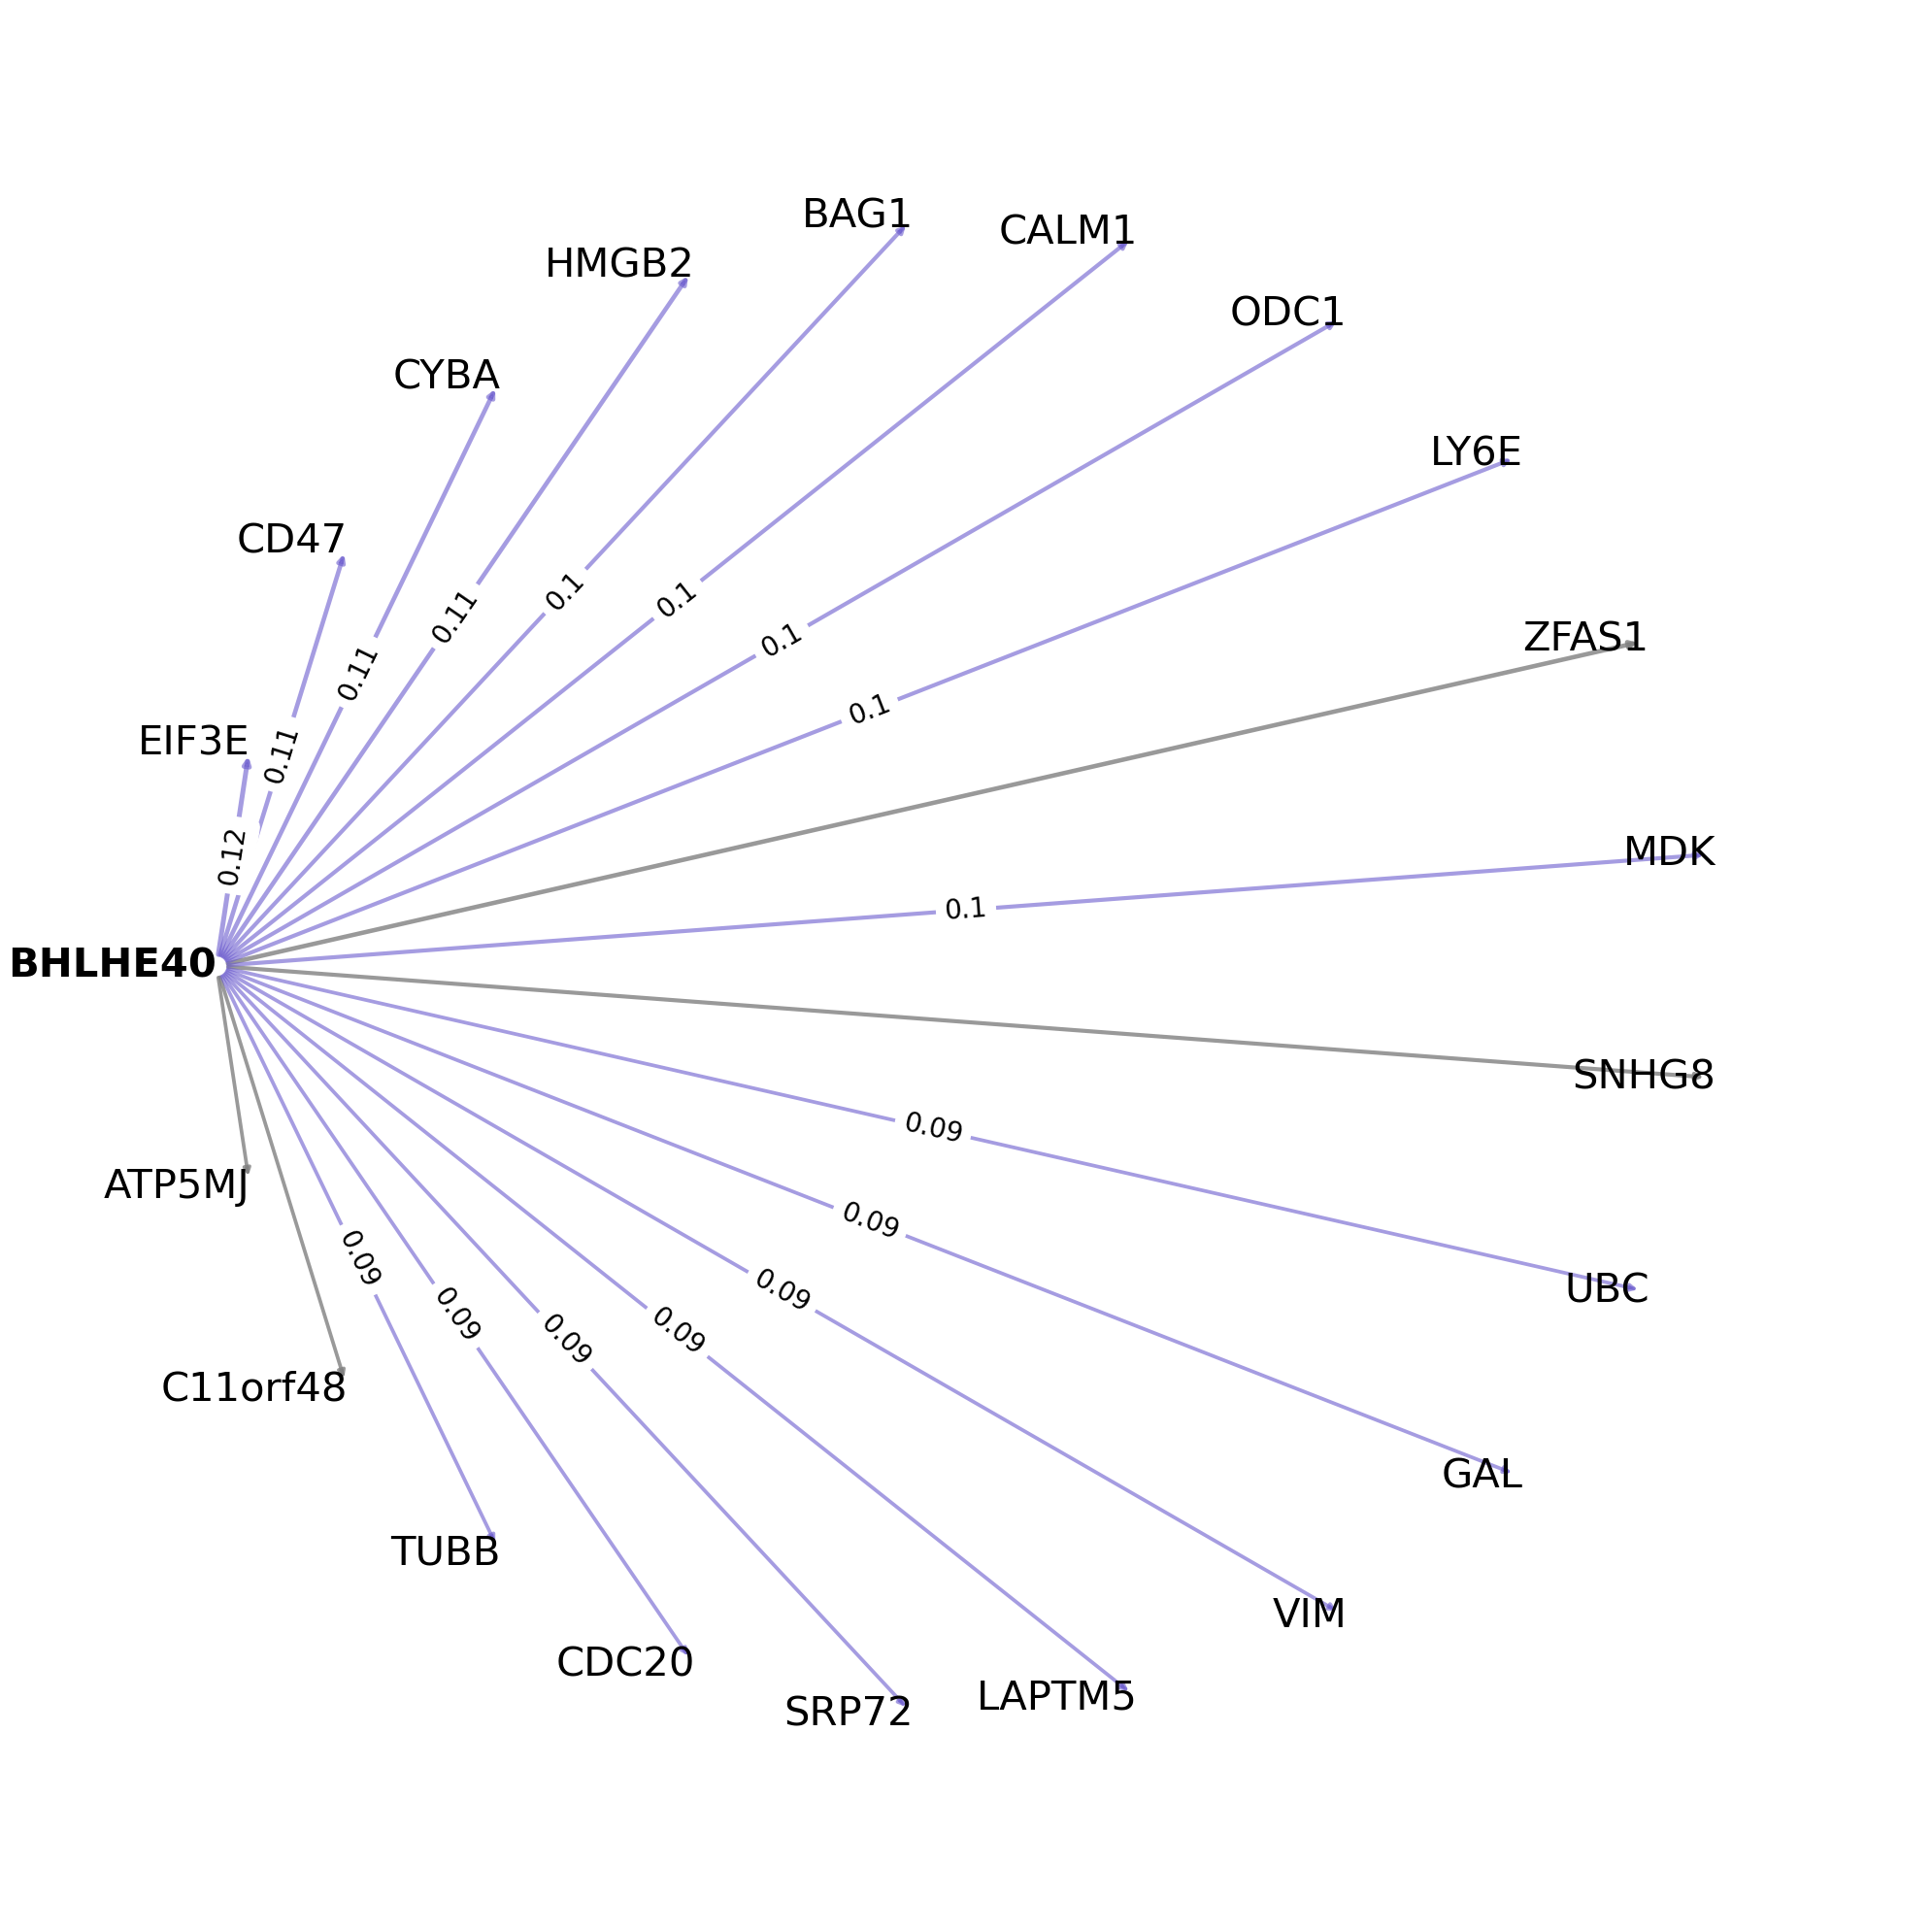

In [32]:
hits = set(gene_list).intersection(set(reference['Target_genes'].values))

G = nx.DiGraph()
edge_list = [(TF_name, gene_list[i], round(score_list[i], 2)) for i in range(len(gene_list))]
G.add_weighted_edges_from(edge_list)

plt.figure(figsize=(20, 20))
edges = list(G.edges)
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if v in hits]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if v not in hits]
pos = nx.shell_layout(G)
width_large = {}
width_small = {}
for i, v in enumerate(edges):
    if v[1] in hits:
        width_large[edges[i]] = G.get_edge_data(v[0], v[1])['weight']*30
    else:
        width_small[edges[i]] = max(G.get_edge_data(v[0], v[1])['weight'], 0)*30
nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='grey',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.6, 
                       edge_color = "slateblue",
                      )
labels = {}
for i in pos.keys():
    if i == TF_name:
        labels[i] = ''
    else:
        labels[i] = i
        
labels1 = {}
for i in pos.keys():
    if i != TF_name:
        labels1[i] = ''
    else:
        labels1[i] = i
nx.draw_networkx_labels(G, pos, labels, font_size=30, font_family="sans-serif", horizontalalignment='right')
nx.draw_networkx_labels(G, pos, labels1, font_size=30, font_family="sans-serif", font_weight='bold', horizontalalignment='right')

d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=20)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


In [24]:
# Validate with Reactome 
df_database = pd.DataFrame(
data = [['GO_Biological_Process_2021', 6036],
['GO_Molecular_Function_2021', 1274],
['Reactome_2022', 1818]],
columns = ['dataset', 'term'])

In [25]:
databases = ['Reactome_2022']
m = df_database[df_database['dataset'].isin(databases)]['term'].sum() #df_database['term'].sum()
p_thresh = 0.05/((len(groups.keys())-1)*m)

In [26]:
gene_list = attn_top_gene_dict_100[TF_name + '+ctrl']
print(gene_list)

['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2', 'UBE2S', 'HMBS', 'PKM', 'CALR', 'MAD2L1', 'UFD1', 'HMGN3', 'ADRM1', 'LBR', 'CIR1', 'RPN2', 'DENND2D', 'C19orf10', 'SLC3A2', 'HSP90AA1', 'CCNB1', 'S100A11', 'PYCARD', 'GSTO1', 'TIMP1', 'RBMX', 'TYMS', 'GMFG', 'BEX4', 'DAD1', 'NTRK1', 'TCEAL9', 'RPL39', 'LINC00998', 'TMSB10', 'BRF1', 'ACAT2', 'CACYBP', 'FAM83A', 'SMAGP', 'TK1', 'HN1', 'STMN1', 'CKS1B', 'KPNA2', 'SRSF7', 'NCL', 'GPSM3', 'KLF1', 'CENPF', 'GYPA', 'NPW', 'LINC02001', 'CKS2', 'SEC61B', 'PHF19', 'H2AC6', 'FEN1', 'SETD2', 'MS4A4A', 'CLSPN', 'C2ORF48', 'LMO2', 'SDF2L1', 'STOML2', 'COMT', 'GEM', 'PTTG1', 'H2BC11', 'TUBB', 'EMP3', 'UQCRB', 'EIF3E', 'LY6E', 'SH3BGRL3', 'HMGB2', 'DNAJA1', 'BAG1', 'EGFL7', 'TUBB4B', 'ODC1', 'VIM', 'MGST2', 'LAPTM5', 'SNHG8', 'IFITM2', 'ZFAS1', 'MDK', 'C11orf48', 'SRP72', 'GAL', 'NUCKS1', 'CDC20', 'UBC', 'CALM1', 'CKB', 'ATP5MJ', 'KIAA0101', 'CYBA', 'CD47', 'BHLHE40']


In [27]:
df_attn = pd.DataFrame()
enr_Reactome = gp.enrichr(gene_list=gene_list,
                           gene_sets=databases,
                           organism='Human', 
                           outdir='test',
                           cutoff=0.5)
out = enr_Reactome.results
out['Gene List'] = str(gene_list)
out = out[out['P-value'] < p_thresh]
df_attn = pd.concat([df_attn, out], ignore_index=True)
df_attn

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene List
0,Reactome_2022,"Cell Cycle, Mitotic R-HSA-69278",18/523,1.225930e-10,8.863475e-08,0,0,8.328570,190.075876,HSP90AA1;FEN1;H2AC6;TUBB;TYMS;TUBB4B;CKS1B;CDC...,"['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2'..."
1,Reactome_2022,Cell Cycle R-HSA-1640170,19/654,6.130693e-10,2.216246e-07,0,0,7.029307,149.109471,HSP90AA1;FEN1;H2AC6;TUBB;TYMS;TUBB4B;CKS1B;CDC...,"['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2'..."
2,Reactome_2022,M Phase R-HSA-68886,14/380,7.226373e-09,1.741556e-06,0,0,8.588091,160.988309,HSP90AA1;H2AC6;TUBB;TUBB4B;CDC20;CCNB1;CENPF;P...,"['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2'..."
3,Reactome_2022,Mitotic Anaphase R-HSA-68882,11/232,2.565745e-08,3.877779e-06,0,0,10.882755,190.213493,CDC20;CCNB1;CENPF;PSMD4;PTTG1;UBE2S;TUBB;UBC;T...,"['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2'..."
4,Reactome_2022,Mitotic Metaphase And Anaphase R-HSA-2555396,11/233,2.681728e-08,3.877779e-06,0,0,10.833183,188.868093,CDC20;CCNB1;CENPF;PSMD4;PTTG1;UBE2S;TUBB;UBC;T...,"['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2'..."
5,Reactome_2022,APC/C:Cdc20 Mediated Degradation Of Mitotic Pr...,7/75,1.016744e-07,1.151939e-05,0,0,21.717303,349.680934,CDC20;CCNB1;PSMD4;PTTG1;UBE2S;UBC;MAD2L1,"['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2'..."
6,Reactome_2022,Activation Of APC/C And APC/C:Cdc20 Mediated D...,7/76,1.115294e-07,1.151939e-05,0,0,21.401480,342.615817,CDC20;CCNB1;PSMD4;PTTG1;UBE2S;UBC;MAD2L1,"['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2'..."
7,Reactome_2022,APC/C-mediated Degradation Of Cell Cycle Prote...,7/87,2.849116e-07,2.574888e-05,0,0,18.448537,278.039509,CDC20;CCNB1;PSMD4;PTTG1;UBE2S;UBC;MAD2L1,"['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2'..."
8,Reactome_2022,Regulation Of APC/C Activators Between G1/S An...,6/80,3.171296e-06,2.547608e-04,0,0,16.920341,214.234705,CDC20;CCNB1;PSMD4;UBE2S;UBC;MAD2L1,"['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2'..."
9,Reactome_2022,APC/C:Cdc20 Mediated Degradation Of Cyclin B R...,4/24,6.022792e-06,4.354478e-04,0,0,40.987629,492.669645,CDC20;CCNB1;UBE2S;UBC,"['DNAJB11', 'HNRNPDL', 'PSMD4', 'PAK2', 'H1-2'..."


In [28]:
# 定义文件名，您可以自定义
output_filename_csv = 'enrichment_results.csv'

# 保存 DataFrame 到 CSV 文件
# index=False 是一个重要的参数，它能防止 pandas 将 DataFrame 的行索引写入文件，通常我们不需要它
df_attn.to_csv(output_filename_csv, index=False, encoding='utf-8-sig')

print(f"结果已成功保存到文件: {output_filename_csv}")

结果已成功保存到文件: enrichment_results.csv
